In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()


In [2]:
!pip install keras-tcn

     |████████████████████████████████| 1.1 MB 27.9 MB/s 
     |████████████████████████████████| 462 kB 49.8 MB/s 


In [3]:

from tensorflow.keras.utils import to_categorical
from tcn import compiled_tcn

In [4]:
DDoS=pd.read_csv('/content/dataset_sdn.csv')

In [5]:
DDoS.Protocol.unique()
DDoS['Protocol'] = DDoS['Protocol'].replace('TCP', '0')
DDoS['Protocol'] = DDoS['Protocol'].replace('UDP', '1')
DDoS['Protocol'] = DDoS['Protocol'].replace('ICMP', '2')
DDoS.Protocol.unique()

array(['1', '0', '2'], dtype=object)

In [6]:
DDoS["rx_kbps"] = DDoS["rx_kbps"].fillna(DDoS["rx_kbps"].mean())

In [7]:
DDoS["tot_kbps"] = DDoS["tot_kbps"].fillna(DDoS["tot_kbps"].mean())

In [8]:
from sklearn.model_selection import train_test_split
X = DDoS[['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow','Protocol' ,'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps']]
y = DDoS['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [9]:
# Feature scaling (or standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
model = compiled_tcn(return_sequences=False,
                         num_feat=1,
                         num_classes=2,
                         nb_filters=64,
                         kernel_size=6,
                         dilations=[2 ** i for i in range(2)],
                         nb_stacks=1,
                         opt='adam',
                         lr=0.002,
                         activation='relu',
                         kernel_initializer='he_normal',
                         use_batch_norm=False,
                         use_layer_norm=False,
                         use_weight_norm=False,
                         max_len=X_train[0:1].shape[1],
                         use_skip_connections=True)

x.shape= (None, 64)
model.x = (None, 20, 1)
model.y = (None, 2)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 tcn (TCN)                   (None, 64)                74496     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 74,626
Trainable params: 74,626
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train, y_train, epochs = 20,validation_split=0.2,verbose = 1)

Epoch 1/20
1566/1566 [==============================] - 27s 16ms/step - loss: 0.1321 - accuracy: 0.9501 - val_loss: 0.0805 - val_accuracy: 0.9683
Epoch 2/20
1566/1566 [==============================] - 25s 16ms/step - loss: 0.0663 - accuracy: 0.9756 - val_loss: 0.0417 - val_accuracy: 0.9846
Epoch 3/20
1566/1566 [==============================] - 27s 17ms/step - loss: 0.0462 - accuracy: 0.9828 - val_loss: 0.0329 - val_accuracy: 0.9865
Epoch 4/20
1566/1566 [==============================] - 25s 16ms/step - loss: 0.0420 - accuracy: 0.9852 - val_loss: 0.0262 - val_accuracy: 0.9898
Epoch 5/20
1566/1566 [==============================] - 25s 16ms/step - loss: 0.0354 - accuracy: 0.9871 - val_loss: 0.0241 - val_accuracy: 0.9911
Epoch 6/20
1566/1566 [==============================] - 25s 16ms/step - loss: 0.0310 - accuracy: 0.9886 - val_loss: 0.0260 - val_accuracy: 0.9889
Epoch 7/20
1566/1566 [==============================] - 25s 16ms/step - loss: 0.0277 - accuracy: 0.9896 - val_loss: 0.0224 -

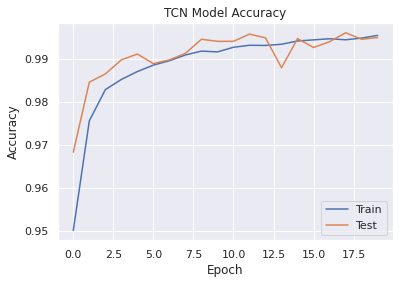

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('TCN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('TCN Model Accuracy.png')
plt.show()

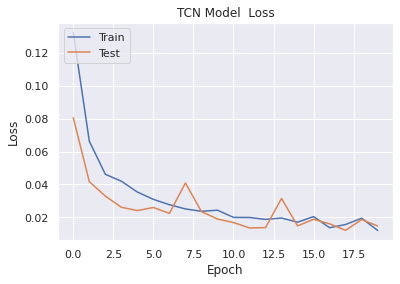

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('TCN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('TCN Model Loss.png')
plt.show()

In [15]:
predict = model.predict(X_test, verbose=1)

1305/1305 [==============================] - 10s 8ms/step


In [16]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1

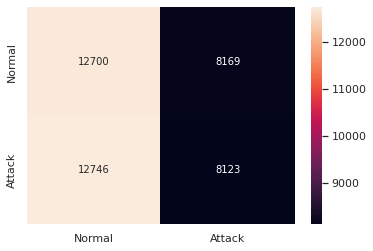

In [17]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Normal","Attack"],columns = ["Normal","Attack"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [18]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.60%
